# Exploratory Data Analysis (EDA)
## US Company Bankruptcy Prediction Dataset

**Projekt:** Entwicklung eines Frühwarnsystems für Unternehmenskrisen mit ML\
**Dataset:** NYSE & NASDAQ Companies (1999-2018)\
**Unternehmen:** 8,262 börsennotierte Unternehmen\
**Beobachtungen:** 78,682 Firm-Year Kombinationen

### Zielsetzung
- Dataset-Eignung für Insolvenzprognose bewerten
- Frühwarn-Indikatoren identifizieren
- Basis für Random Forest / Logit-Modelle schaffen

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
import warnings
warnings.filterwarnings('ignore')

plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette('husl')
plt.rcParams['figure.figsize'] = (12, 6)
%matplotlib inline
print('✓ Libraries loaded')

✓ Libraries loaded


## 1. Feature Definitions

18 Bilanzkennzahlen (Financial Ratios):

In [2]:
# Feature Mapping
FEATURES = {
    "X1": {
        "name": "Current Assets",
        "de": "Umlaufverm\u00f6gen"
    },
    "X2": {
        "name": "Cost of Goods Sold",
        "de": "Herstellungskosten"
    },
    "X3": {
        "name": "Depreciation & Amortization",
        "de": "Abschreibungen"
    },
    "X4": {
        "name": "EBITDA",
        "de": "EBITDA"
    },
    "X5": {
        "name": "Inventory",
        "de": "Lagerbestand"
    },
    "X6": {
        "name": "Net Income",
        "de": "Nettogewinn"
    },
    "X7": {
        "name": "Total Receivables",
        "de": "Forderungen"
    },
    "X8": {
        "name": "Market Value (Cap)",
        "de": "Marktwert"
    },
    "X9": {
        "name": "Net Sales",
        "de": "Nettoumsatz"
    },
    "X10": {
        "name": "Total Assets",
        "de": "Gesamtverm\u00f6gen"
    },
    "X11": {
        "name": "Total Long-term Debt",
        "de": "Langfristige Verbindlichkeiten"
    },
    "X12": {
        "name": "EBIT",
        "de": "EBIT"
    },
    "X13": {
        "name": "Gross Profit",
        "de": "Bruttogewinn"
    },
    "X14": {
        "name": "Total Current Liabilities",
        "de": "Kurzfristige Verbindlichkeiten"
    },
    "X15": {
        "name": "Retained Earnings",
        "de": "Gewinnr\u00fccklagen"
    },
    "X16": {
        "name": "Total Revenue",
        "de": "Gesamtumsatz"
    },
    "X17": {
        "name": "Total Liabilities",
        "de": "Gesamtverbindlichkeiten"
    },
    "X18": {
        "name": "Total Operating Expenses",
        "de": "Betriebsausgaben"
    }
}

# Als DataFrame
features_df = pd.DataFrame(FEATURES).T
features_df.index.name = 'Feature'
print('📊 BILANZKENNZAHLEN\n')
features_df

📊 BILANZKENNZAHLEN



,name,de
Feature,,
X1,Current Assets,Umlaufvermögen
X2,Cost of Goods Sold,Herstellungskosten
X3,Depreciation & Amortization,Abschreibungen
X4,EBITDA,EBITDA
X5,Inventory,Lagerbestand
X6,Net Income,Nettogewinn
X7,Total Receivables,Forderungen
X8,Market Value (Cap),Marktwert
X9,Net Sales,Nettoumsatz


## 2. Daten Laden

In [3]:
df = pd.read_csv('american_bankruptcy.csv')
print(f'Shape: {df.shape}')
print(f'Zeitraum: {df["year"].min()} - {df["year"].max()}')
print(f'Unternehmen: {df["company_name"].nunique():,}')
df.head()

Shape: (78682, 21)
Zeitraum: 1999 - 2018
Unternehmen: 8,971


,company_name,status_label,year,X1,X2,X3,X4,X5,X6,X7,...,X9,X10,X11,X12,X13,X14,X15,X16,X17,X18
0,C_1,alive,1999,511.267,833.107,18.373,89.031,336.018,35.163,128.348,...,1024.333,740.998,180.447,70.658,191.226,163.816,201.026,1024.333,401.483,935.302
1,C_1,alive,2000,485.856,713.811,18.577,64.367,320.590,18.531,115.187,...,874.255,701.854,179.987,45.790,160.444,125.392,204.065,874.255,361.642,809.888
2,C_1,alive,2001,436.656,526.477,22.496,27.207,286.588,-58.939,77.528,...,638.721,710.199,217.699,4.711,112.244,150.464,139.603,638.721,399.964,611.514
3,C_1,alive,2002,396.412,496.747,27.172,30.745,259.954,-12.410,66.322,...,606.337,686.621,164.658,3.573,109.590,203.575,124.106,606.337,391.633,575.592
4,C_1,alive,2003,432.204,523.302,26.680,47.491,247.245,3.504,104.661,...,651.958,709.292,248.666,20.811,128.656,131.261,131.884,651.958,407.608,604.467


## 3. Zielvariable: Insolvenz-Status

**SEC Definition:**
- Chapter 11: Reorganization
- Chapter 7: Complete cessation


Status Distribution:
status_label
alive     73462
failed     5220
Name: count, dtype: int64

Imbalance Ratio: 1:14.1


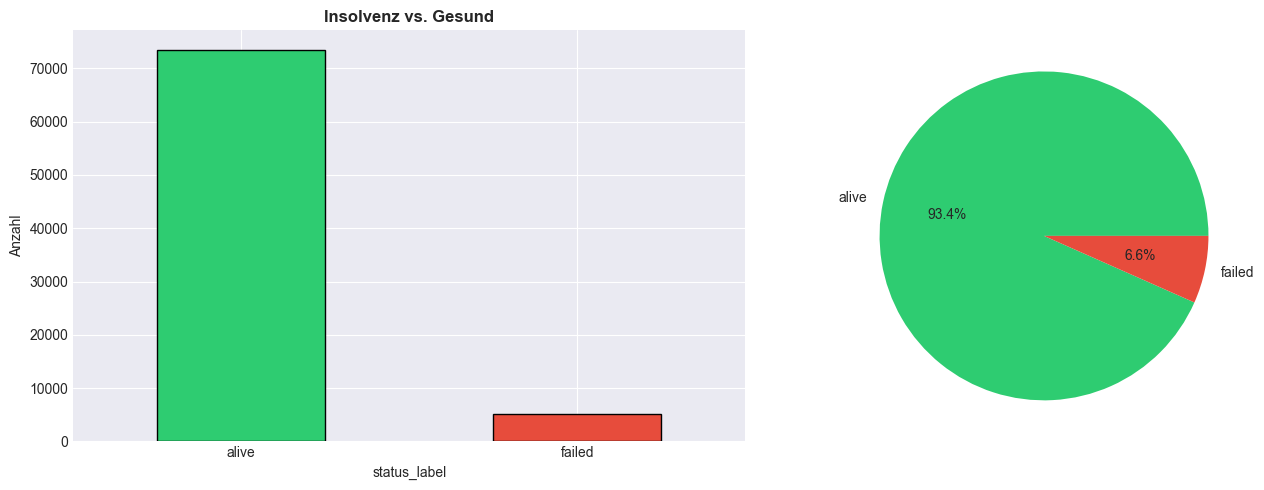

In [4]:
status = df['status_label'].value_counts()
print('\nStatus Distribution:')
print(status)
print(f'\nImbalance Ratio: 1:{status.iloc[0]/status.iloc[1]:.1f}')

# Visualization
fig, axes = plt.subplots(1, 2, figsize=(14, 5))
colors = ['#2ecc71', '#e74c3c']
status.plot(kind='bar', ax=axes[0], color=colors, edgecolor='black')
axes[0].set_title('Insolvenz vs. Gesund', fontweight='bold')
axes[0].set_ylabel('Anzahl')
axes[0].tick_params(rotation=0)
status.plot(kind='pie', ax=axes[1], autopct='%1.1f%%', colors=colors)
axes[1].set_ylabel('')
plt.tight_layout()
plt.show()

## 4. Zeitreihen-Struktur

Unternehmen: 8,971
Ø Jahre/Unternehmen: 8.77
Mit Zeitreihen (>1 Jahr): 8,216


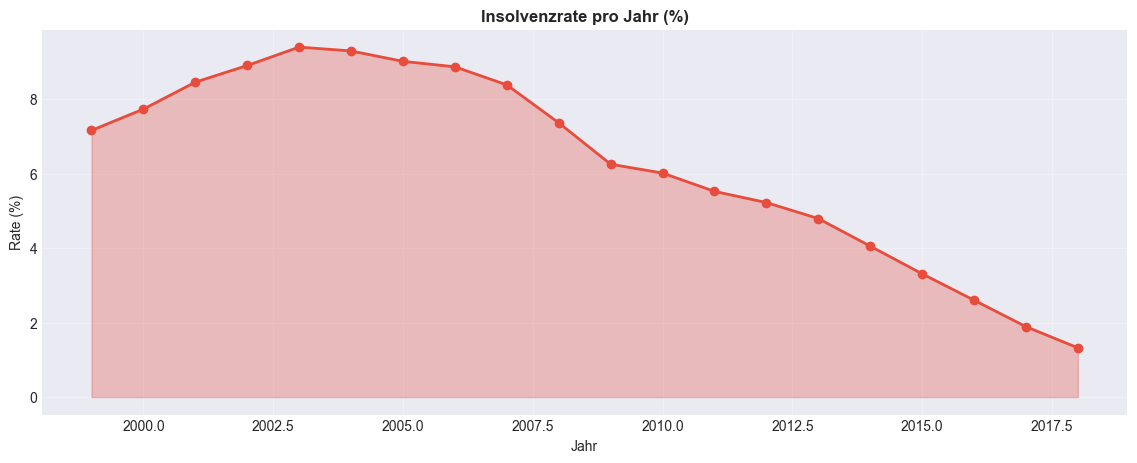

In [5]:
# Years per company
years_per_company = df.groupby('company_name')['year'].count()
print(f'Unternehmen: {len(years_per_company):,}')
print(f'Ø Jahre/Unternehmen: {years_per_company.mean():.2f}')
print(f'Mit Zeitreihen (>1 Jahr): {(years_per_company>1).sum():,}')

# Bankruptcy over time
bk_year = df.groupby('year')['status_label'].apply(lambda x: (x=='failed').sum())
total_year = df.groupby('year').size()
bk_rate = (bk_year / total_year * 100)

plt.figure(figsize=(14, 5))
plt.plot(bk_rate.index, bk_rate.values, marker='o', linewidth=2, color='#e74c3c')
plt.fill_between(bk_rate.index, bk_rate.values, alpha=0.3, color='#e74c3c')
plt.title('Insolvenzrate pro Jahr (%)', fontweight='bold')
plt.xlabel('Jahr')
plt.ylabel('Rate (%)')
plt.grid(alpha=0.3)
plt.show()

## 5. Datenqualität

In [6]:
print('Missing Values:', df.isnull().sum().sum())
print('Duplicates:', df.duplicated().sum())
print('\n✓ Dataset ist sauber!' if df.isnull().sum().sum()==0 else '⚠️ Cleaning needed')

Missing Values: 0
Duplicates: 0

✓ Dataset ist sauber!


## 6. Feature-Statistiken

In [7]:
feature_cols = [c for c in df.columns if c.startswith('X')]
stats = df[feature_cols].describe().T
stats['feature_name'] = [FEATURES[c]['name'] for c in stats.index]
stats[['feature_name', 'mean', 'std', 'min', '50%', 'max']].round(2)

,feature_name,mean,std,min,50%,max
X1,Current Assets,880.36,3928.56,-7.76,100.45,169662.00
X2,Cost of Goods Sold,1594.53,8930.48,-366.64,103.66,374623.00
X3,Depreciation & Amortization,121.23,652.38,0.00,7.93,28430.00
X4,EBITDA,376.76,2012.02,-21913.00,15.03,81730.00
X5,Inventory,201.61,1060.77,0.00,7.02,62567.00
X6,Net Income,129.38,1265.53,-98696.00,1.62,104821.00
X7,Total Receivables,286.83,1335.98,-0.01,22.82,65812.00
X8,Market Value (Cap),3414.35,18414.10,0.00,227.51,1073390.54
X9,Net Sales,2364.02,11950.07,-1965.00,186.60,511729.00
X10,Total Assets,2867.11,12917.94,0.00,213.20,531864.00


## 7. Feature-Verteilungen

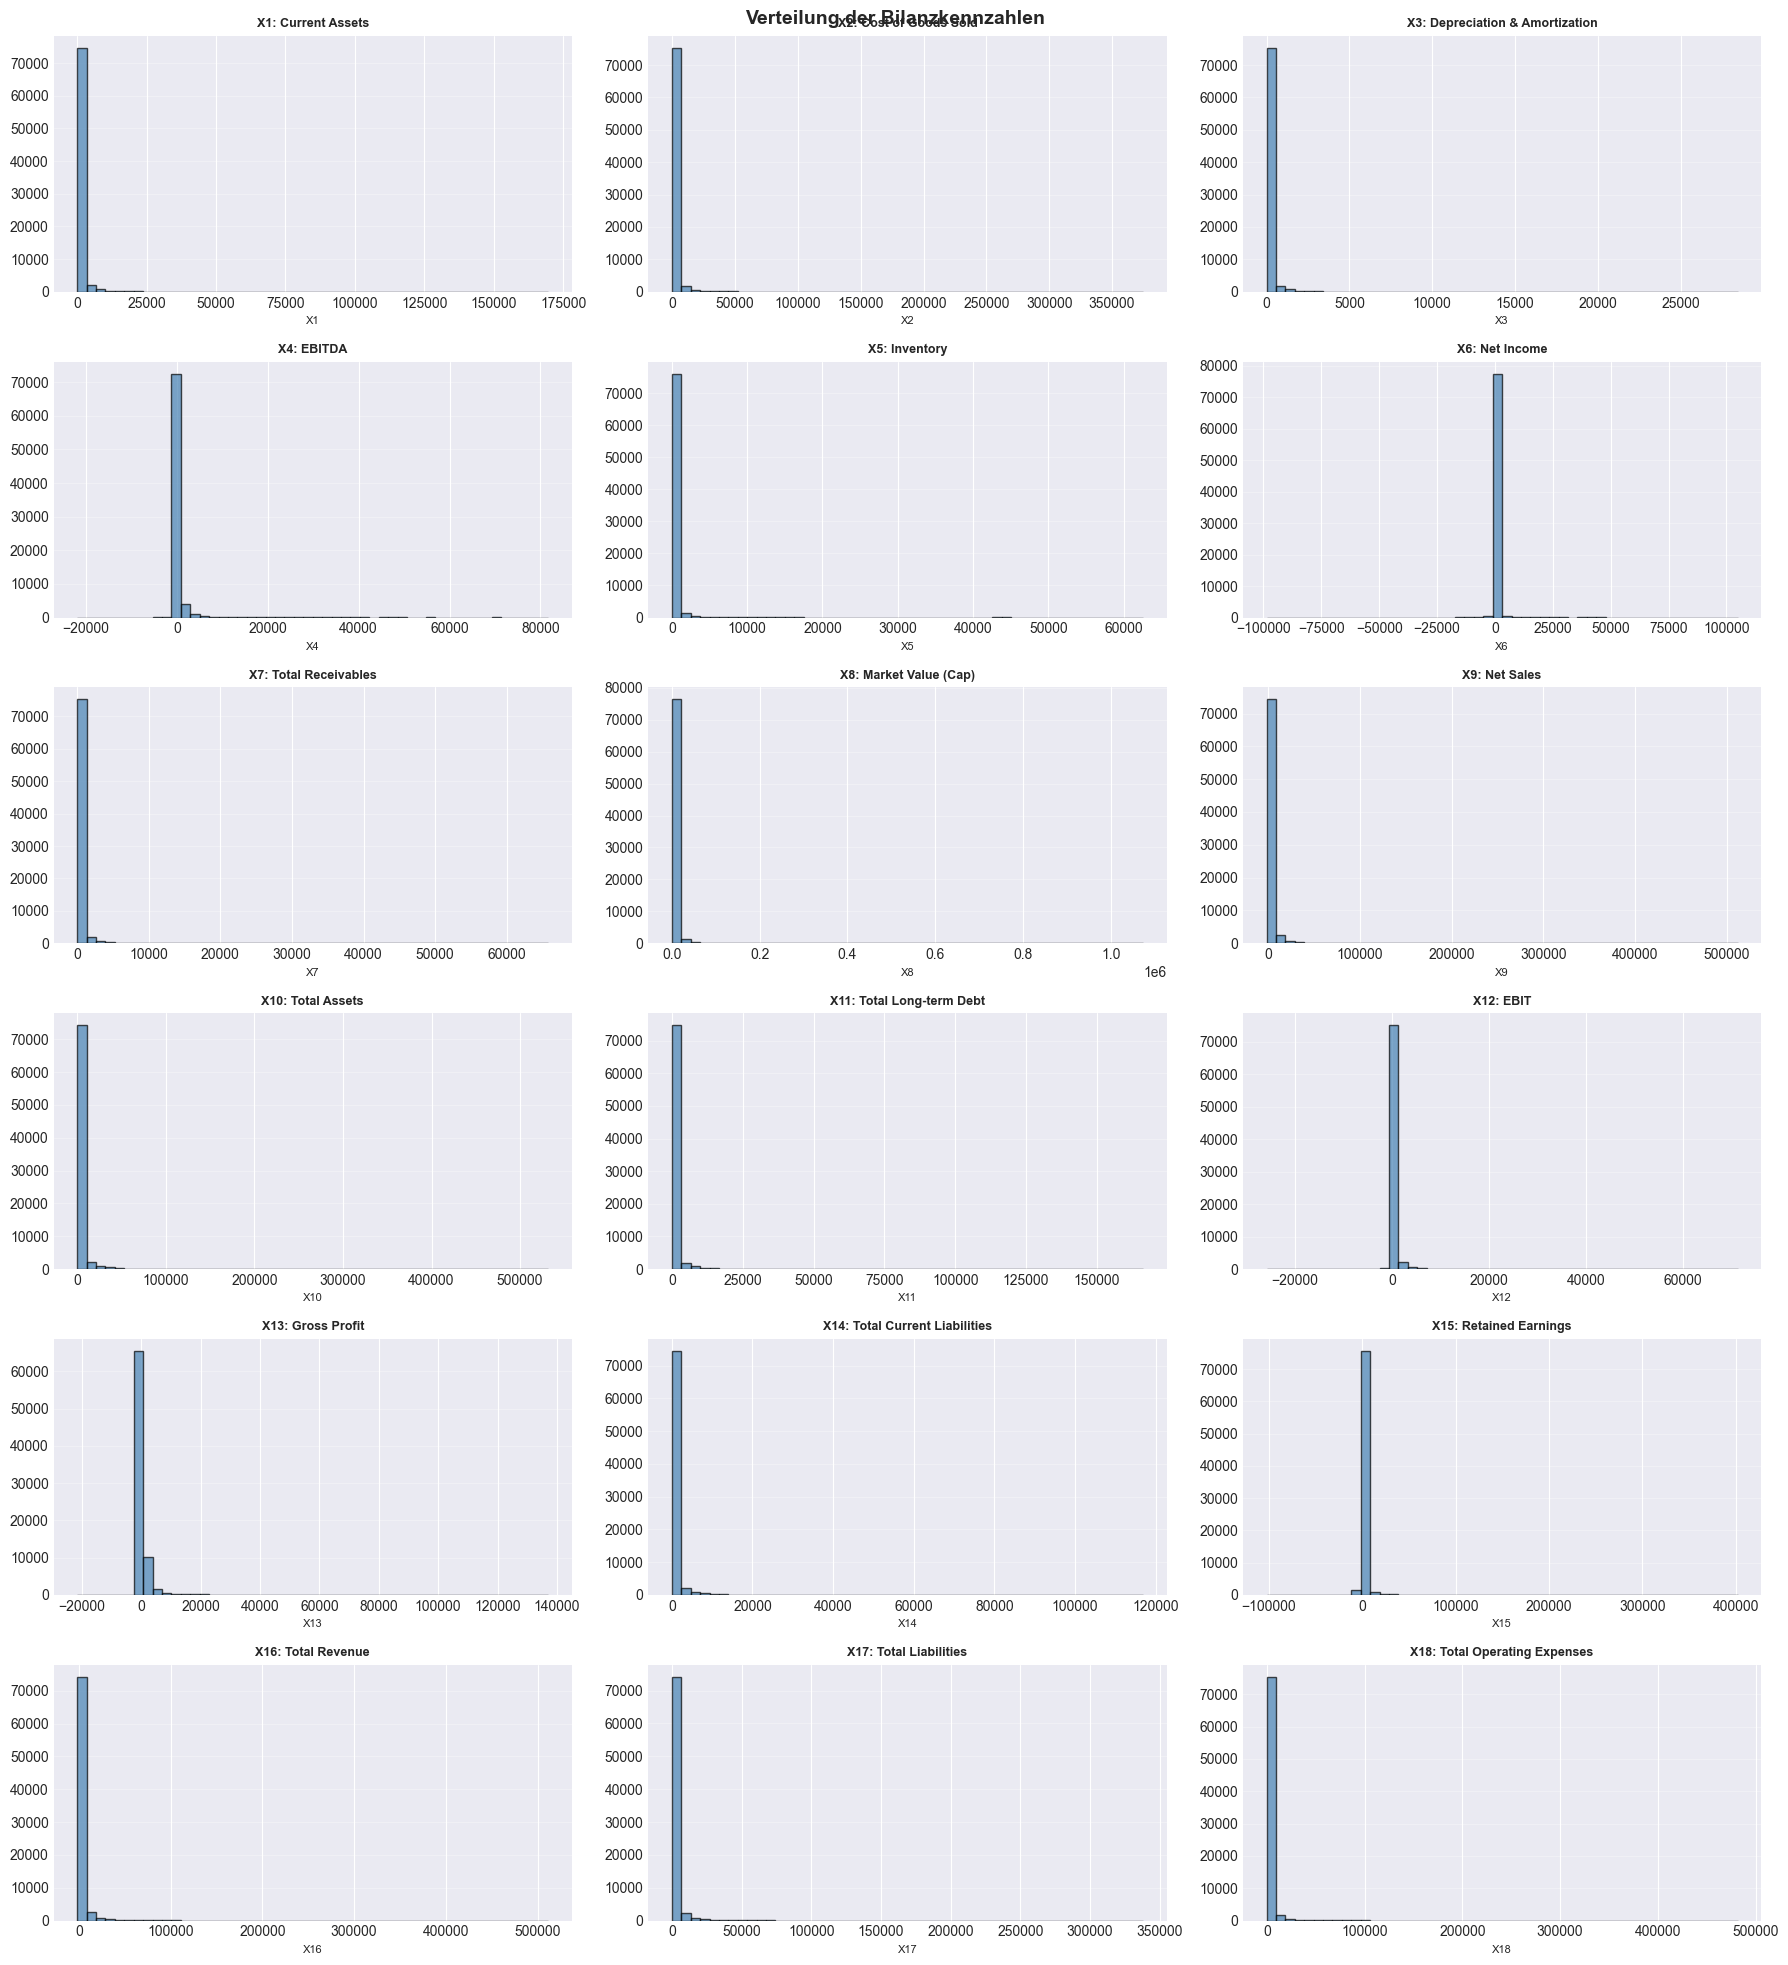

In [8]:
fig, axes = plt.subplots(6, 3, figsize=(18, 20))
axes = axes.ravel()
for idx, col in enumerate(feature_cols):
    axes[idx].hist(df[col], bins=50, alpha=0.7, color='steelblue', edgecolor='black')
    axes[idx].set_title(f"{col}: {FEATURES[col]['name']}", fontsize=9, fontweight='bold')
    axes[idx].set_xlabel(col, fontsize=8)
    axes[idx].grid(axis='y', alpha=0.3)
plt.suptitle('Verteilung der Bilanzkennzahlen', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

## 8. Feature-Unterschiede: Bankrott vs. Gesund

In [9]:
alive = df[df['status_label']=='alive'][feature_cols]
failed = df[df['status_label']=='failed'][feature_cols]

comp = pd.DataFrame({
    'Feature': [FEATURES[c]['name'] for c in feature_cols],
    'Alive_Mean': alive.mean().values,
    'Failed_Mean': failed.mean().values,
    'Diff': (alive.mean() - failed.mean()).values,
    'Alive_Std': alive.std().values,
    'Failed_Std': failed.std().values
}, index=feature_cols)

comp['Effect_Size'] = comp['Diff'] / np.sqrt((comp['Alive_Std']**2 + comp['Failed_Std']**2)/2)
comp = comp.sort_values('Effect_Size', key=abs, ascending=False)

print('Feature-Vergleich (sortiert nach Effect Size):\n')
comp[['Feature', 'Alive_Mean', 'Failed_Mean', 'Diff', 'Effect_Size']].round(2)

Feature-Vergleich (sortiert nach Effect Size):



,Feature,Alive_Mean,Failed_Mean,Diff,Effect_Size
X8,Market Value (Cap),3596.02,857.81,2738.20,0.20
X12,EBIT,269.94,52.69,217.25,0.19
X6,Net Income,141.99,-48.11,190.11,0.19
X1,Current Assets,914.54,399.34,515.20,0.17
X4,EBITDA,393.68,138.57,255.12,0.17
X13,Gross Profit,800.89,327.62,473.27,0.17
X7,Total Receivables,297.79,132.57,165.23,0.16
X15,Retained Earnings,582.03,-165.11,747.14,0.15
X16,Total Revenue,2447.87,1183.96,1263.91,0.14
X9,Net Sales,2447.87,1183.96,1263.91,0.14


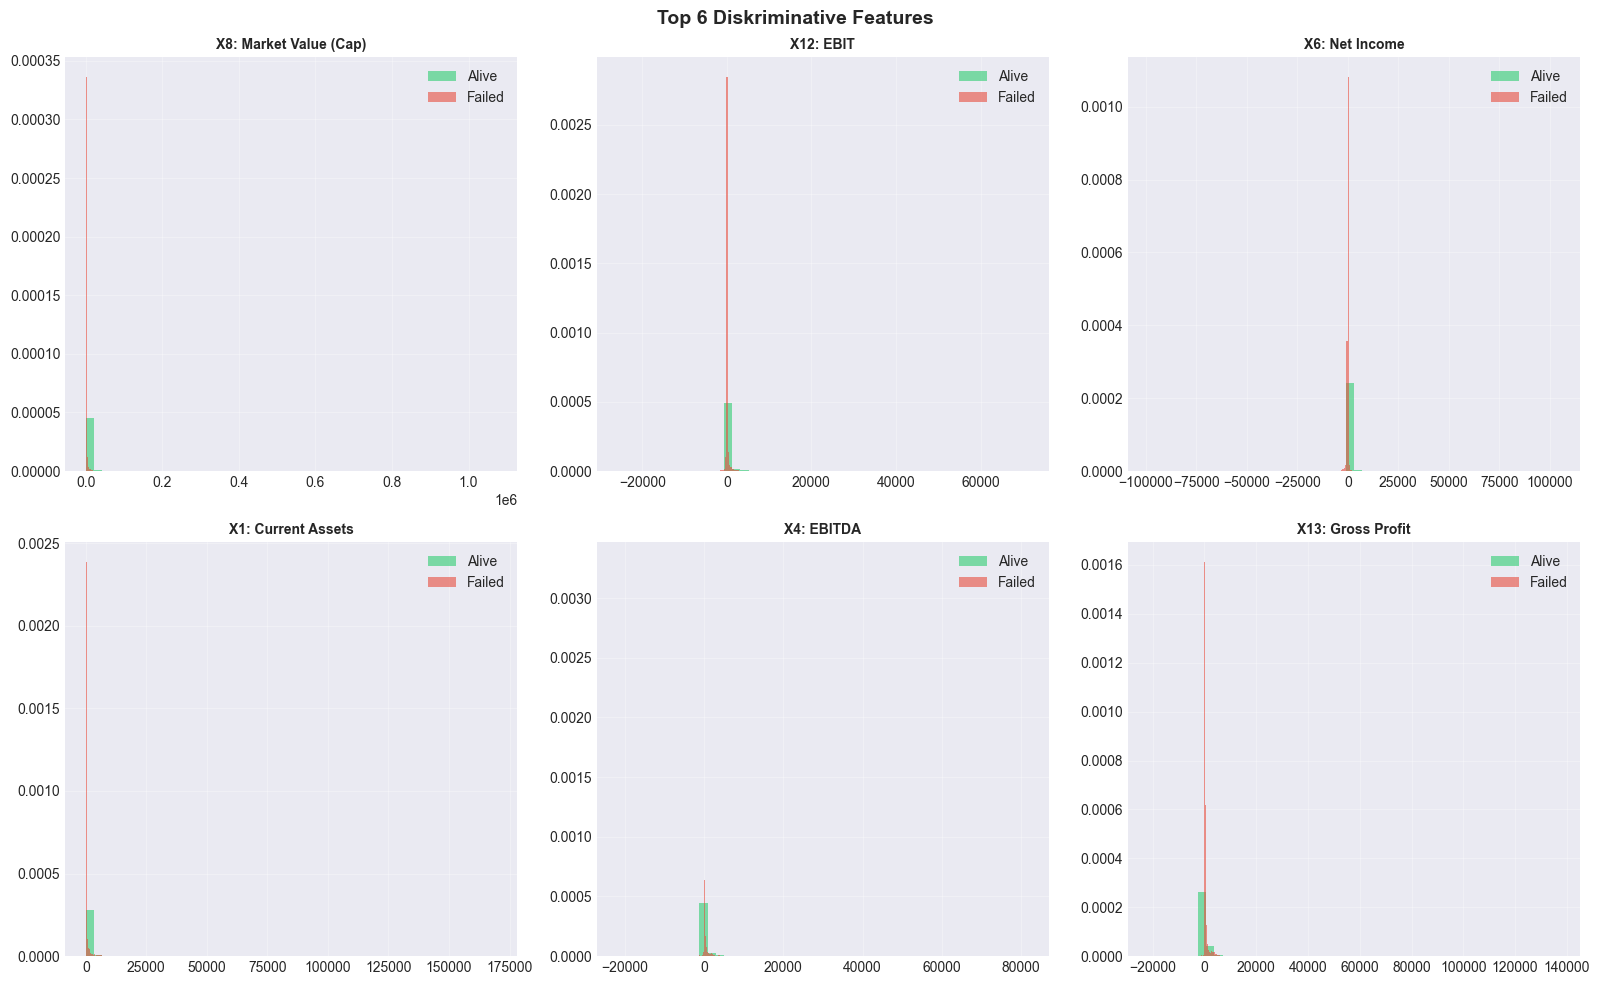

In [10]:
top_features = comp.head(6).index
fig, axes = plt.subplots(2, 3, figsize=(16, 10))
axes = axes.ravel()

for idx, col in enumerate(top_features):
    alive_data = df[df['status_label']=='alive'][col]
    failed_data = df[df['status_label']=='failed'][col]
    axes[idx].hist(alive_data, bins=50, alpha=0.6, label='Alive', color='#2ecc71', density=True)
    axes[idx].hist(failed_data, bins=50, alpha=0.6, label='Failed', color='#e74c3c', density=True)
    axes[idx].set_title(f"{col}: {FEATURES[col]['name']}", fontsize=10, fontweight='bold')
    axes[idx].legend()
    axes[idx].grid(alpha=0.3)

plt.suptitle('Top 6 Diskriminative Features', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

## 9. Korrelationsanalyse

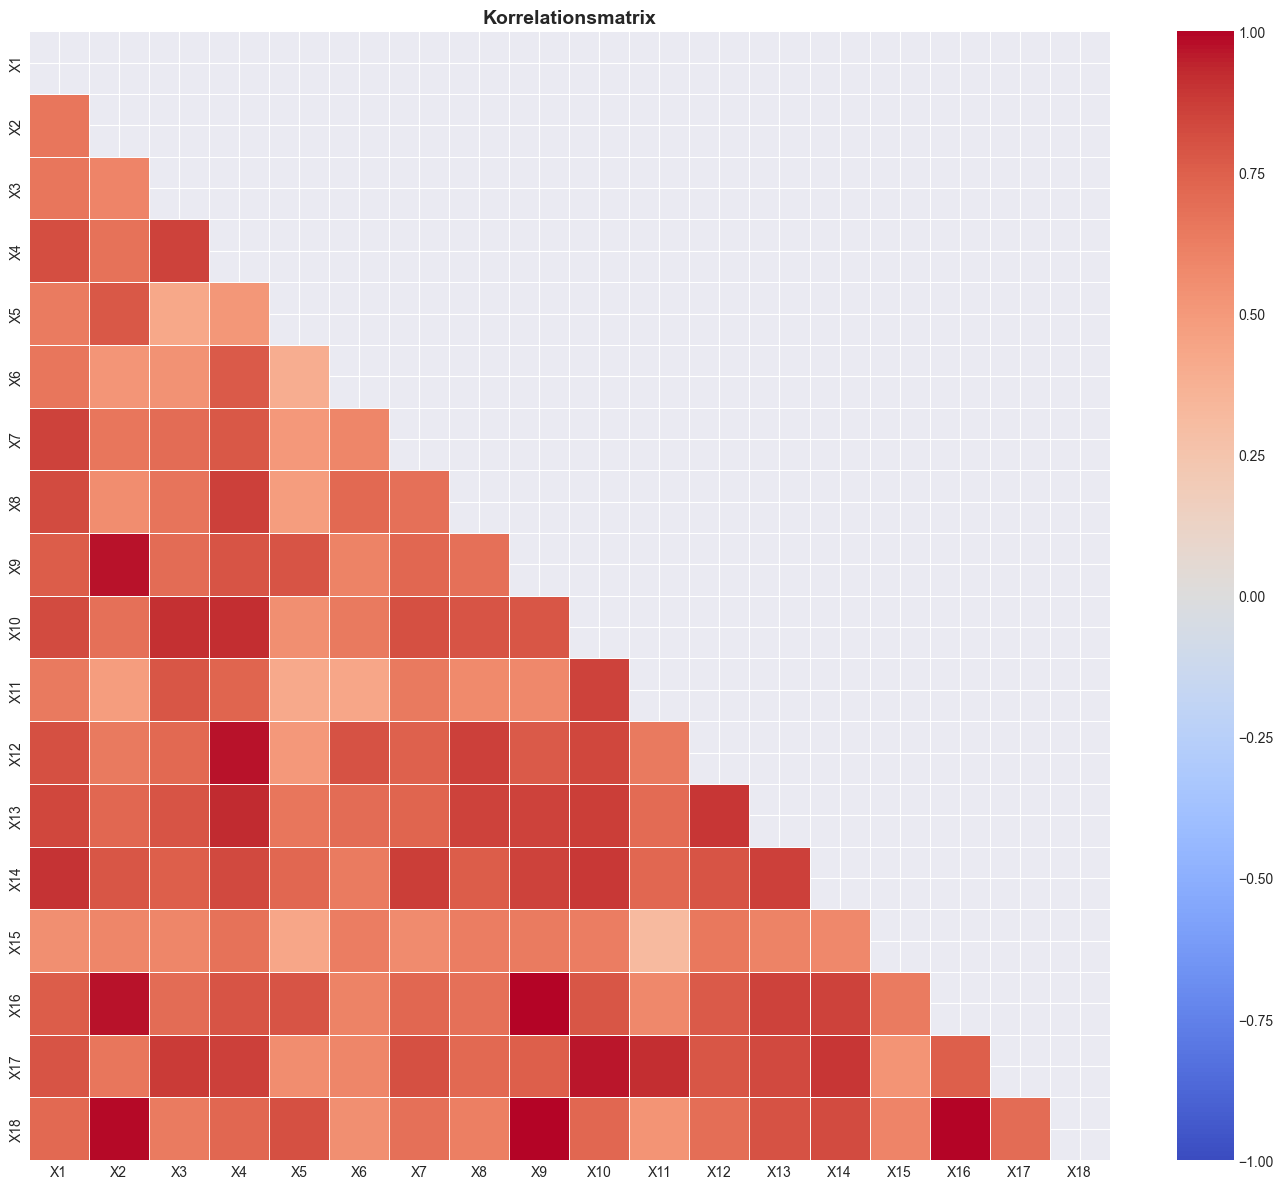

In [11]:
corr = df[feature_cols].corr()

plt.figure(figsize=(14, 12))
mask = np.triu(np.ones_like(corr, dtype=bool))
sns.heatmap(corr, mask=mask, annot=False, cmap='coolwarm', center=0, 
            linewidths=0.5, vmin=-1, vmax=1)
plt.title('Korrelationsmatrix', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

In [12]:
# Stark korrelierte Paare
high_corr = []
for i in range(len(corr.columns)):
    for j in range(i+1, len(corr.columns)):
        if abs(corr.iloc[i,j]) > 0.8:
            high_corr.append({
                'Feature 1': corr.columns[i],
                'Feature 2': corr.columns[j],
                'Correlation': corr.iloc[i,j]
            })

if high_corr:
    print(f'\n⚠️ {len(high_corr)} stark korrelierte Paare (|r|>0.8):')
    pd.DataFrame(high_corr).sort_values('Correlation', ascending=False)
else:
    print('✓ Keine starke Multikollinearität (|r|>0.8)')


⚠️ 44 stark korrelierte Paare (|r|>0.8):


## 10. Zusammenfassung & Empfehlungen

In [13]:
print('='*70)
print('DATASET-BEWERTUNG FÜR FRÜHWARNSYSTEM')
print('='*70)

print('\n✓ STÄRKEN:')
print('  • 18 Bilanzkennzahlen als Prädiktoren')
print('  • Klare Zielvariable: Insolvenz')
print(f'  • {df["company_name"].nunique():,} Unternehmen mit Zeitreihen')
print(f'  • {len(df):,} Beobachtungen')
print('  • Keine Missing Values')
print('  • Features zeigen klare Unterschiede')

imb = df['status_label'].value_counts()
ratio = imb.iloc[0]/imb.iloc[1]
print('\n⚠️ HERAUSFORDERUNGEN:')
print(f'  • Klassenimbalance: 1:{ratio:.1f}')
print('  • Amerikanische Unternehmen (vs. deutsche Bilanzen)')

print('\n📊 EMPFOHLENE MODELLE:')
print('  1. Logistische Regression (mit Class Weights)')
print('  2. Random Forest (robust)')
print('  3. XGBoost/LightGBM')
print('  4. Ensemble-Methoden')

print('\n🔧 NÄCHSTE SCHRITTE:')
print('  1. Feature Engineering: Zeitliche Trends, Änderungsraten')
print('  2. Umgang mit Imbalance: SMOTE, Class Weights')
print('  3. Feature Selection')
print('  4. Cross-Validation (zeitbasiert!)')
print('  5. Modell-Training')

print('\n✅ FAZIT: Dataset ist GEEIGNET für Insolvenz-Frühwarnsystem!')
print('='*70)

DATASET-BEWERTUNG FÜR FRÜHWARNSYSTEM

✓ STÄRKEN:
  • 18 Bilanzkennzahlen als Prädiktoren
  • Klare Zielvariable: Insolvenz
  • 8,971 Unternehmen mit Zeitreihen
  • 78,682 Beobachtungen
  • Keine Missing Values
  • Features zeigen klare Unterschiede

⚠️ HERAUSFORDERUNGEN:
  • Klassenimbalance: 1:14.1
  • Amerikanische Unternehmen (vs. deutsche Bilanzen)

📊 EMPFOHLENE MODELLE:
  1. Logistische Regression (mit Class Weights)
  2. Random Forest (robust)
  3. XGBoost/LightGBM
  4. Ensemble-Methoden

🔧 NÄCHSTE SCHRITTE:
  1. Feature Engineering: Zeitliche Trends, Änderungsraten
  2. Umgang mit Imbalance: SMOTE, Class Weights
  3. Feature Selection
  4. Cross-Validation (zeitbasiert!)
  5. Modell-Training

✅ FAZIT: Dataset ist GEEIGNET für Insolvenz-Frühwarnsystem!


## 11. Export bereinigte Daten

In [ ]:
df.to_csv('american_bankruptcy_cleaned.csv', index=False)
print('✓ Bereinigte Daten gespeichert: american_bankruptcy_cleaned.csv')